## 模型训练

该代码为模型训练的运行文件。

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import time
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim.lr_scheduler as lr_scheduler

from sklearn.preprocessing import MinMaxScaler

from transformer import DataGenerator, Transformer, train, evaluate
from torchsummary import summary

torch.manual_seed(0)
np.random.seed(0)

### 数据集介绍

该数据集包含2008~2016年每一天每一个时刻的天气情况数据，时间精确到小时，天气情况数据包括温度、气压、相对湿度、风速等，相应数据按照时间升序进行排序，其具体数据见于weather_train.csv和weather_test.csv。

在该项目中，我们使用Transformer进行气温预测，即在已知某一时间点前温度、气压、相对湿度、风速等指标的情况下，预测这个时间点后的气温值。

In [2]:
# 读取csv数据，进行一些初步的处理
# 设置时间格式
def date_parser(date_string):
    return pd.datetime.strptime(date_string, '%d.%m.%Y %H:%M:%S')

data_train = pd.read_csv("weather_train.csv", parse_dates = ['Date Time'], date_parser=date_parser)
data_train.sort_values(by='Date Time', ascending=True, inplace=True)

data_train.head()

/tmp/ipykernel_24011/2390687744.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime.strptime(date_string, '%d.%m.%Y %H:%M:%S')


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
1,2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2,2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
3,2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
4,2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


<Axes: xlabel='Date Time'>

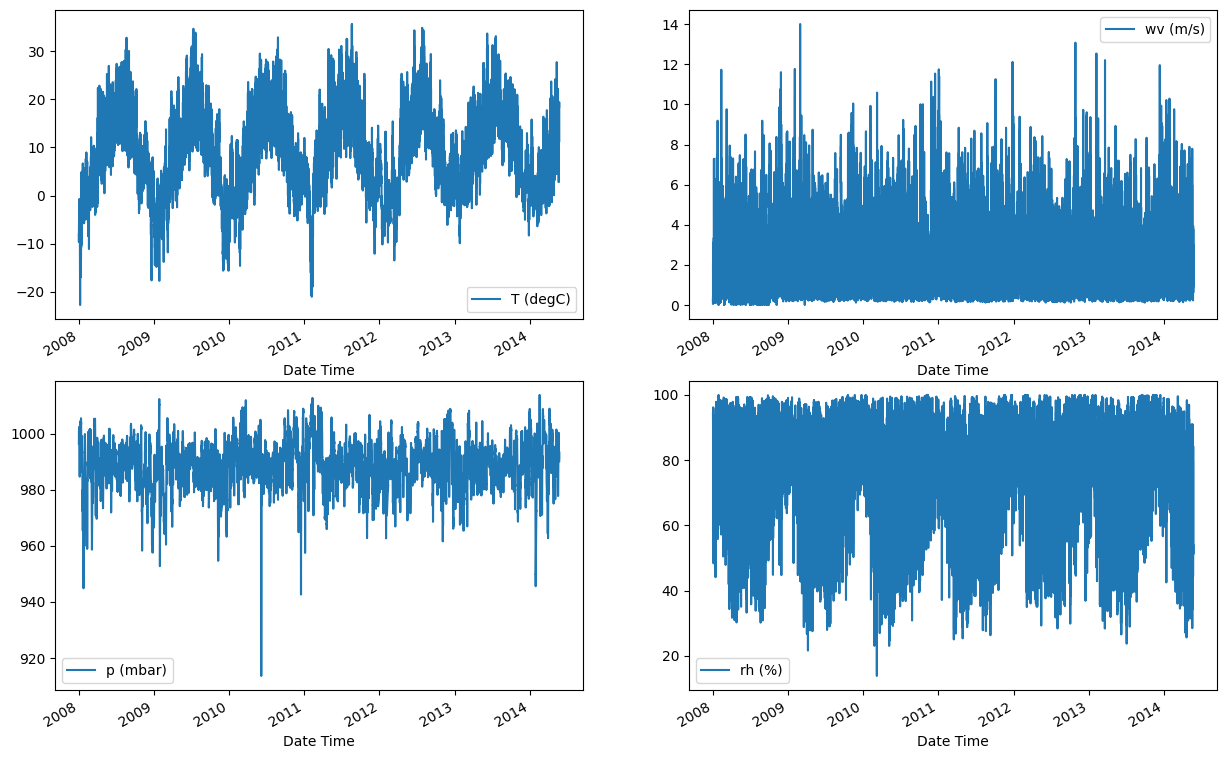

In [3]:
# 数据可视化，分别包含四种指标
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

data_train.plot(ax=ax[0][0], x="Date Time", y="T (degC)")
data_train.plot(ax=ax[1][0], x="Date Time", y="p (mbar)")
data_train.plot(ax=ax[1][1], x="Date Time", y="rh (%)")
data_train.plot(ax=ax[0][1], x="Date Time", y="wv (m/s)")

In [4]:
# 在训练前删除时间列，不加载到数据集中
data_train['Date Time'] = data_train['Date Time'].apply(lambda x: x.replace(minute=0))
data_train.drop("Date Time", inplace=True, axis=1)
train_dataset = data_train.copy()

# 数据归一化
scaler = MinMaxScaler(feature_range=(-1, 1))
train_dataset[train_dataset.columns] = scaler.fit_transform(train_dataset)
train_dataset.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,0.652876,-0.496319,-0.506454,-0.330547,0.869949,-0.917727,-0.830175,-0.990905,-0.834852,-0.832438,0.487084,-0.970021,-0.946383,0.070556
1,0.655269,-0.524739,-0.534986,-0.371918,0.842081,-0.925048,-0.847668,-0.989947,-0.851936,-0.849624,0.513365,-0.964311,-0.946383,0.057222
2,0.659655,-0.522342,-0.533288,-0.367321,0.849048,-0.924699,-0.845481,-0.990426,-0.849658,-0.847476,0.512946,-0.974304,-0.946383,-0.071111
3,0.662646,-0.530560,-0.541780,-0.382365,0.828147,-0.926791,-0.851312,-0.988990,-0.855353,-0.853921,0.521506,-0.985724,-0.967660,0.333333
4,0.672017,-0.550419,-0.562840,-0.408692,0.818857,-0.931323,-0.861516,-0.988990,-0.865604,-0.863946,0.542938,-0.942898,-0.925106,-0.127778


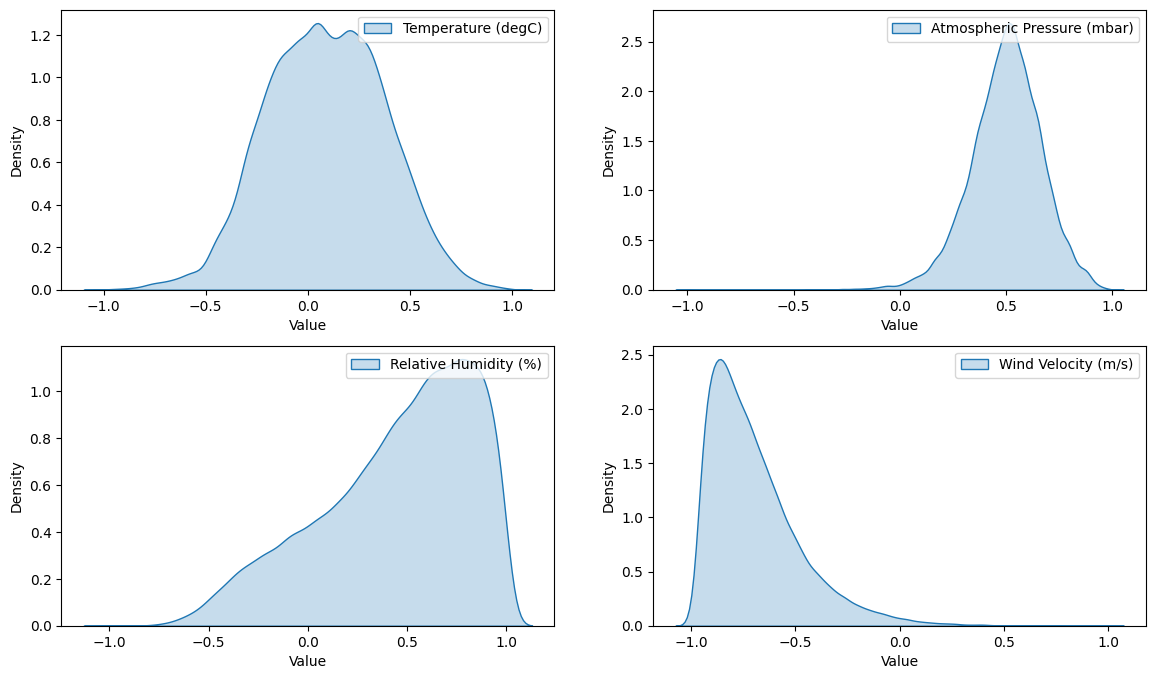

In [5]:
# 数据集各指标分布画图
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

sns.kdeplot(train_dataset['T (degC)'], fill=True,  label='Temperature (degC)', ax=axes[0])
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Density')
axes[0].legend()

sns.kdeplot(train_dataset['p (mbar)'], fill=True,  label='Atmospheric Pressure (mbar)', ax=axes[1])
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Density')
axes[1].legend()

sns.kdeplot(train_dataset['rh (%)'], fill=True,  label='Relative Humidity (%)', ax=axes[2])
axes[2].set_xlabel('Value')
axes[2].set_ylabel('Density')
axes[2].legend()

sns.kdeplot(train_dataset['wv (m/s)'], fill=True,  label='Wind Velocity (m/s)', ax=axes[3])
axes[3].set_xlabel('Value')
axes[3].set_ylabel('Density')
axes[3].legend()

In [6]:
epochs = 50
lr = 1e-3
batch_size = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device : {device}")

Using device : cuda


### 数据集加载

具体内容见于transformer_model.py

In [7]:
data_generator = DataGenerator(train_dataset)

train_size = int(0.7 * len(data_generator))
val_size = int(0.2 * len(data_generator))
test_size = len(data_generator) - train_size - val_size

train_generator, val_generator, test_generator = random_split(data_generator, [train_size, val_size, test_size])

train_loader = DataLoader(train_generator, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_generator, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_generator, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

### 模型训练

使用Transformer模型进行训练，采用均方根误差作损失函数，Adam优化器，具体内容见于transformer_model.py

In [8]:
model = Transformer().to(device)

summary(model, (120, 13))

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model, train_losses, val_losses, lrs = train(model, criterion, optimizer, None, epochs, train_loader, val_loader, device, "model.pth")

/root/miniconda3/lib/python3.8/site-packages/torch/nn/modules/transformer.py:544: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._transformer_encoder_layer_fwd(


Layer (type:depth-idx)                        Output Shape              Param #
├─Linear: 1-1                                 [-1, 120, 100]            1,400
├─PositionalEncoding: 1-2                     [-1, 120, 100]            --
├─TransformerEncoder: 1-3                     [-1, 120, 100]            --
|    └─ModuleList: 2                          []                        --
|    |    └─TransformerEncoderLayer: 3-1      [-1, 120, 100]            452,548
├─Linear: 1-4                                 [-1, 24]                  288,024
Total params: 741,972
Trainable params: 741,972
Non-trainable params: 0
Total mult-adds (M): 1.19
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 2.83
Estimated Total Size (MB): 2.93


Epochs: 100%|██████████| 50/50 [05:26<00:00,  6.53s/it, lr=0.001, train_loss=0.00416, val_loss=0.00416]

Training time: 326.32 seconds


模型保存

In [9]:
print("Saving final model")
torch.save(model.state_dict(), "model_final.pth")

Saving final model


In [10]:
print(f"Final losses | Train loss: {train_losses[-1]:.4f} | Val loss: {val_losses[-1]:.4f}")

Final losses | Train loss: 0.0042 | Val loss: 0.0042


损失值曲线绘制

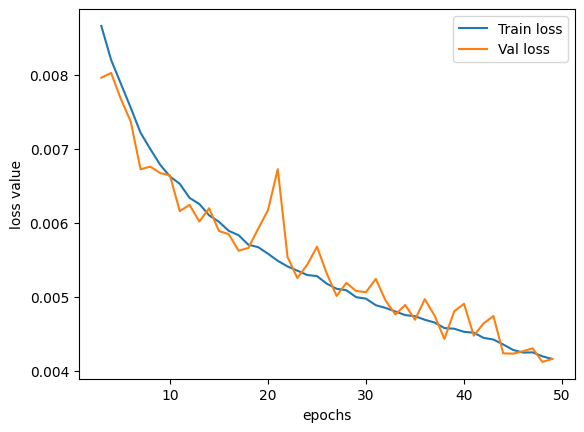

In [11]:
start_epoch = 3
plt.plot(list(range(start_epoch, len(train_losses))), train_losses[start_epoch:], label="Train loss")
plt.plot(list(range(start_epoch, len(train_losses))), val_losses[start_epoch:], label="Val loss")
plt.xlabel("epochs")
plt.ylabel("loss value")
plt.legend()

### 损失值随预测时间跨度变化曲线

由于模型预测的是24小时内的气温值，气温距离当前时刻越远，预测偏差就会越大，因此理论上以预测时间跨度为单独指标分别计算损失值，得到的损失值结果会随着时间的推移而上升。

[0.00092939 0.00152713 0.00213698 0.00276269 0.00320626 0.00353924
 0.00380146 0.00396021 0.00411221 0.00422451 0.00426486 0.00433135
 0.00439108 0.00453096 0.00463574 0.00474652 0.00488168 0.00498858
 0.00510435 0.00523985 0.00537989 0.00556693 0.0058363  0.00597153]


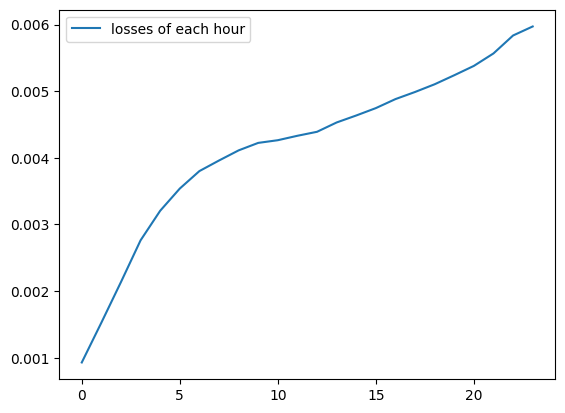

In [12]:
losses = evaluate(model, criterion, val_loader, device, separate_labels=True)
print(losses)
plt.plot(losses, label="losses of each hour")
plt.legend()

[0.00091442 0.00144304 0.00206994 0.00270307 0.00321076 0.00353341
 0.00374947 0.00392861 0.0041236  0.00425317 0.00439232 0.00448904
 0.00469773 0.00481362 0.0048641  0.00490732 0.00494323 0.00496948
 0.00510997 0.00519912 0.00532041 0.00543454 0.00561054 0.0058502 ]


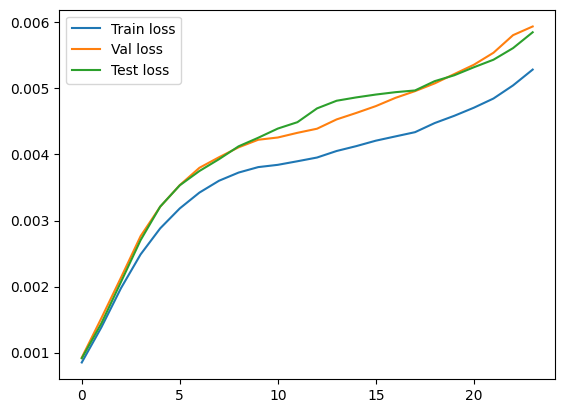

In [13]:
train_losses = evaluate(model, criterion, train_loader, device, separate_labels=True, prediction_length=24)
val_losses = evaluate(model, criterion, val_loader, device, separate_labels=True, prediction_length=24)
test_losses = evaluate(model, criterion, test_loader, device, separate_labels=True, prediction_length=24)
print(test_losses)
np.array(test_losses).mean()
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.plot(test_losses, label="Test loss")
plt.legend()